In [299]:
import json
import requests
import pandas as pd
import numpy as np
import networkx as nx
import nxpd
import matplotlib.pyplot as plt
import matplotlib
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql import dataframe
import graphframes


from src.data_reader import DataReader, RetractionFinder
from src.to_gexf import to_gexf
from src.get_redacted import get_paper, load_redacted, get_doi, gen_retracted
import src.load_data as load_data

In [300]:
df_full = load_data.load_dataframe(source='data/retracted_articles', limit=-1)
df = load_data.format_dataframe(df_full)

# EDA

In [356]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [354]:
X,y = df.loc[:, ['numInCitations','numAuthors', 'numEntities', 'year', 'pageLength']], df['retracted']
X,y = df.drop('retracted', axis=1), df['retracted']
X0,Xt,y0,yt = train_test_split(X,y)

In [336]:
rf = RandomForestClassifier(criterion='entropy', max_features='sqrt', 
                            max_depth=2, n_jobs=-1, n_estimators=1000,
                            random_state=5476)
gbc = GradientBoostingClassifier(max_features='sqrt',
                                 max_depth=2, n_estimators=1000,
                                 random_state=5476)

rf.fit(X0, y0)
gbc.fit(X0, y0)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=2,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=5476, subsample=1.0, verbose=0,
              warm_start=False)

In [337]:
print(log_loss(y_pred=rf.predict_proba(Xt)[:,1], y_true=yt))
print(log_loss(y_pred=gbc.predict_proba(Xt)[:,1], y_true=yt))

0.18197707141172098
0.17657723375813605


<BarContainer object of 5 artists>

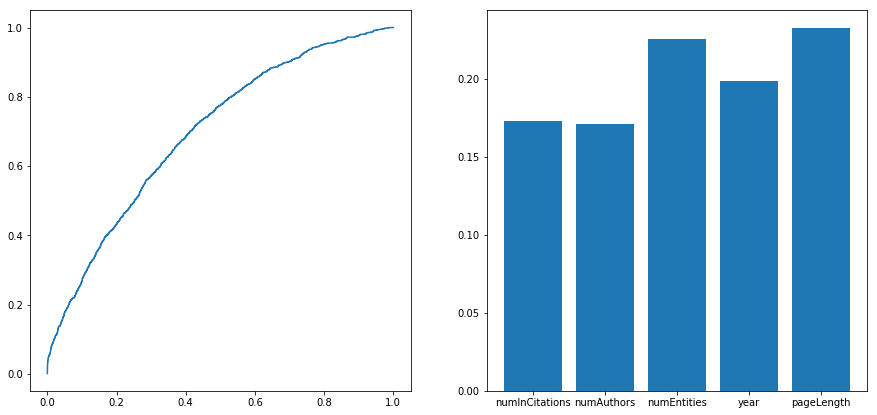

In [338]:
fpr, tpr, thr = roc_curve(y_score=gbc.predict_proba(Xt)[:,1], y_true=yt)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(15,7))
ax0.plot(fpr, tpr)
ax1.bar(x=X.columns, height=gbc.feature_importances_)

In [339]:
def plot_proportions(X, y, lbl):
    xx, yy = [], []
    for val in np.unique(X[lbl]):
        xx.append(val)
        y_hat = y[X[lbl] == val]
        yy.append(y_hat.sum()/len(y_hat))
    return xx,yy

(0, 50)

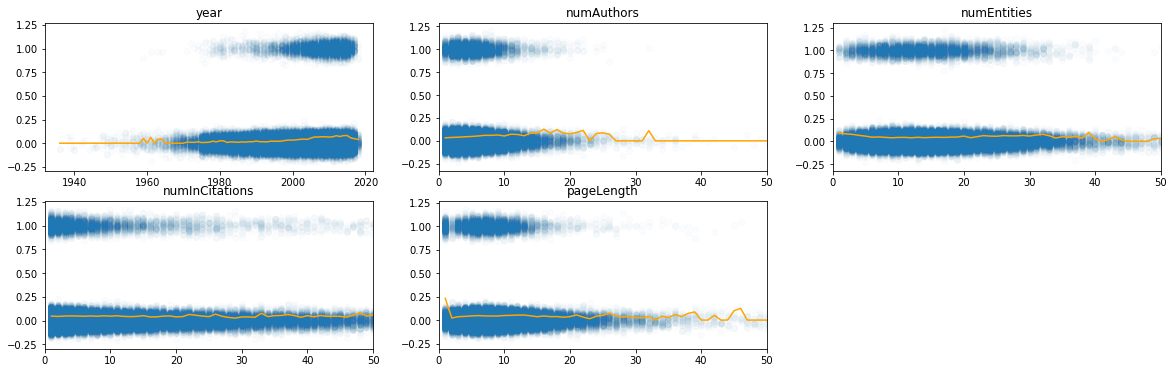

In [340]:
plt.subplots(figsize=(20,6))
plt.subplot('231')
plt.scatter(X['year'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'year'), c='orange')
plt.title('year')

plt.subplot('232')
plt.scatter(X['numAuthors'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'numAuthors'), c='orange')
plt.xlim(0,50)
plt.title('numAuthors')

plt.subplot('233')
plt.scatter(X['numEntities'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'numEntities'), c='orange')
plt.xlim(0,50)
plt.title('numEntities')

plt.subplot('234')
plt.scatter(X['numInCitations'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'numInCitations'), c='orange')
plt.xlim(0,50)
plt.title('numInCitations')

plt.subplot('235')
plt.scatter(X['pageLength'], y + np.random.normal(loc=0, scale=0.05, size=len(y)), alpha=0.02)
plt.plot(*plot_proportions(X,y,'pageLength'), c='orange')
plt.title('pageLength')
plt.xlim(0,50)


In [196]:
has_p_value = df_full['paperAbstract'].apply(lambda x: any(p in x.lower() for p in ('pvalue','p-value', 'p value')))

In [294]:
print(len(df_full['paperAbstract'][has_p_value & df['retracted']]), sum(df['retracted']))
print(len(df_full['paperAbstract'][has_p_value & df['retracted']])/sum(df['retracted']))
print(np.std([has_p_value & df['retracted']]))

15 4905
0.0030581039755351682
0.00901105701332872


In [295]:
print(len(df_full['paperAbstract'][has_p_value & ~df['retracted']]), sum(~df['retracted']))
print(len(df_full['paperAbstract'][has_p_value & ~df['retracted']])/sum(~df['retracted']))
print(np.std([has_p_value & ~df['retracted']]))

311 99814
0.0031157953794056946
0.04099793903598765


,id,title,journalName,paperAbstract,inCitations,outCitations,numInCitations,authors,numAuthors,entities,numEntities,venue,sources,year,pageLength,retracted
0,04c5e2d01d1724b50016d911c1e9438e4096f7ef,Dapoxetine: a novel treatment for premature ej...,Drugs of today,Premature ejaculation (PE) is a common problem...,[605c17f96fe75102dd9155de91a3b9a364673f43],[],1,"[{'name': 'R T Owen', 'ids': ['38939497']}]",1,"[Adverse reaction to drug, Anxiety Disorders, ...",17,Drugs of today,[Medline],2009.0,10.0,False
2,72fe9b4ca545436d68f6f75f987a599a31428af4,Bilateral tonic-clonic seizures with temporal ...,Neurology,nomenon implies that withdrawal of treatment r...,"[6c2317cbfeffd9e62acfc225de6c5dc9054d9c5e, e62...",[],3,"[{'name': 'R G Nogueira', 'ids': ['1845059']},...",5,"[Actual Discomfort, Benzodiazepines, Biologic ...",16,Neurology,[Medline],2008.0,3.0,False
3,7167b15cc8a3c4348c108173d1de25eaf9756dbf,Effects of withdrawing vs continuing renin-ang...,American heart journal,BACKGROUND\nIt is unclear if holding angiotens...,"[3e37f080269aca7383351cfa3fdf46596e88f927, ebe...",[],9,"[{'name': 'Kevin R Bainey', 'ids': ['5025188']...",8,"[ACE protein, human, Angiotensin II receptor a...",20,American heart journal,[Medline],2015.0,7.0,False
8,7443de292855c44fa6bb4dca31ce07816d3f6e5e,Zanamivir: a review of clinical safety.,Drug safety,Preclinical and clinical studies have clearly ...,"[372fcfd74ff4f579704d40ec8fe524357534ef22, d49...",[],14,"[{'name': 'B Freund', 'ids': ['2755691']}, {'n...",4,"[Adverse event, Adverse reaction to drug, Aman...",20,Drug safety,[Medline],1999.0,15.0,False
11,cc0ae19058f89ab5ec8e96ab89eb86deb9d7ac8b,Drug reaction with eosinophilia and systemic s...,The British journal of dermatology,We report a case of drug reaction with eosinop...,"[56ff708d8bb24404168453a0f162075b97ef0d6d, 11c...","[e14a515dee48188a96f3cba600d55c0fe055de29, 9ef...",2,"[{'name': 'A Almudimeegh', 'ids': ['12889553']...",6,"[Adrenal Cortex Hormones, Adverse reaction to ...",22,The British journal of dermatology,[Medline],2014.0,4.0,False
15,1fbe8c622045af3fdb2519b255cf617c0af386fa,"Leptin, gastrointestinal and stress hormones i...",Journal of physiology and pharmacology : an of...,"Leptin, an ob gene product of adipocytes, play...","[79ed3bb8bfce2f9e6fa936d002dbd4b988d5d98c, a3b...",[],10,"[{'name': 'Z Sliwowski', 'ids': ['5569243']}, ...",5,"[Adipocytes, Catecholamines, Cholecystokinin, ...",21,Journal of physiology and pharmacology : an of...,[Medline],2001.0,18.0,False
16,eb5749074bb4a9979d9051ed93b345bb491d126c,"[The Omega ""Omega"" pulley plasty. A new techni...",Annales de chirurgie plastique et esthetique,The authors report a new technique of pulley p...,"[55b4ccec284f7bf848907338cbee13368ecb78fb, a94...",[],4,"[{'name': 'J Bakhach', 'ids': ['3991884']}, {'...",6,"[Anatomic structures, Body cavities, Bone Tiss...",24,Annales de chirurgie plastique et esthetique,[Medline],2005.0,10.0,False
17,88f294738bbd953794d275a31ab6e69f03329b94,Risk for delirium tremens in patients with alc...,Substance abuse,To determine the characteristics associated wi...,"[959a90ef2836c16ecf3b6375047c655dd11a2f08, b5a...",[],18,"[{'name': 'David A Fiellin', 'ids': ['4105330'...",4,"[Alcohol Withdrawal Delirium, Alcohol Withdraw...",11,Substance abuse,[Medline],2002.0,12.0,False
19,224495f9340c055c5ae84f6f360ef26260478158,Positional abnormalities during sleep in child...,Medical hypotheses,Sleep-related breathing disorders (SRBD) are d...,"[91259349282db63a0e0b354d4d1bb54065f78bfc, a11...","[f76807edcef589bf02a691554386dfc0afa3dc38, d9e...",13,"[{'name': 'Marco Carotenuto', 'ids': ['4056797...",5,"[Airway Obstruction, Alveolar, Apnea, Blood Co...",17,Medical hypotheses,[Medline],2013.0,3.0,False
20,959973873fb467a287f17ec7a4dce006bf5feb56,"ZP8, a neuronal zinc sensor with improved dyna...",Inorganic chemistry,The synthesis of a difluorofluorescein monocar...,"[d1888cda47c8613f5fa33beb04a74d94903bb3a5, d0a...",[],7,"[{'name': 'Christopher J Chang', 'ids': ['2459...",

In [298]:
df_full.columns

Index(['authors', 'doi', 'doiUrl', 'entities', 'id', 'inCitations',
       'journalName', 'journalPages', 'journalVolume', 'outCitations',
       'paperAbstract', 'pdfUrls', 'pmid', 's2PdfUrl', 's2Url', 'sources',
       'title', 'venue', 'year'],
      dtype='object')

In [364]:
abstract_tfidf = TfidfVectorizer()
abstract_tfidf.fit(X0['paperAbstract'])
abstract_train = abstract_tfidf.transform(X0['paperAbstract'])
abstract_test = abstract_tfidf.transform(Xt['paperAbstract'])

abstract_bayes = MultinomialNB()
abstract_bayes.fit(abstract_train, y0)
log_loss(y_pred=abstract_bayes.predict_proba(abstract_test)[:,1], y_true=yt)

0.5046382018902034

In [362]:
title_tfidf = TfidfVectorizer()
title_tfidf.fit(X0['title'])
title_train = title_tfidf.transform(X0['title'])
title_test = title_tfidf.transform(Xt['title'])


title_bayes = MultinomialNB()
title_bayes.fit(title_train, y0)
log_loss(y_pred=title_bayes.predict_proba(title_test)[:,1], y_true=yt)

0.2345321452809765